# BF550 Lab 4 Fall 2022

In this lab, we will work with data in Pandas and visualization with Seaborn. We will learn common, but complicated Pandas operations such as melt and merge. I have left cell outputs with the intended solution, but your task will be to write the corresponding code (unless otherwise noted).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 0. Seaborn review

With [Seaborn](https://seaborn.pydata.org/) we can plot categorical data by using the column names of a pandas Dataframe:

In [2]:
"Load data"
tips = sns.load_dataset('tips')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


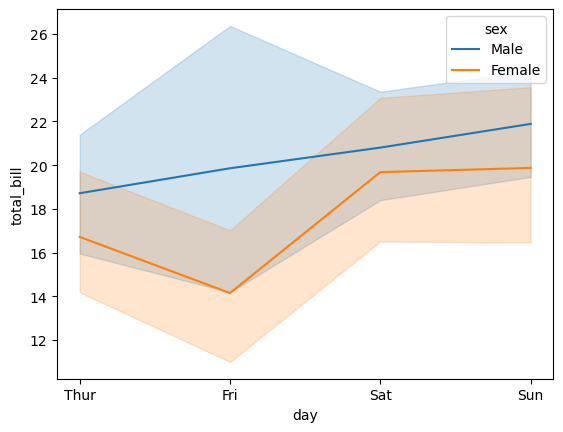

In [3]:
"Plot data"
# Create a lineplot where:
# days are on the x axis
# total_bill is on the y axis
# colored by sex
sns.lineplot(data=tips, x='day', y='total_bill', hue='sex')
plt.show()

## Categorical data and transformations
Note that the data we want to plot must be in a **column** in order for us to point Seaborn towards it (each argument we pass to a Seaborn function is the name of a column in our dataframe). The data we want won't always be in columns, so we may have to *transform* the data.

# Exercise: visualizing counts data
In the following lab **you will visualize count data over time from different locations**. 

Notice that your typical count dataset is a table of samples and features (the count of each feature in each sample, where a feature can be a gene, species, etc.)

| **Sample** | Feature 1 | Feature 2 | ... | Feature N |
| --- | --- | --- | --- | ---|
| **S1** | S1F1 | S1F2 | ... | S1FN |
| **S2**  | S2F1 | S2F2 | ... | S2FN |

If we wanted to color by `feature` like how we colored by `sex` in the previous plot, note that the format that this data is in won't allow us to do that. There is no column specifying the `feature`. 

We will have to transform the data so that `feature` becomes a column and each value of the matrix gets its own row:

| Sample | feature| value |
| --- | --- | --- |
| S1 | Feature 1 | S1F1|
| S1 | Feature 2| S1F2|
| S2 | Feature 1| S2F1|
| S2 | Feature 2| S2F2|
| ... | ... | ... |
| S1 | Feature N | S1FN|
| S2 | Feature N | S2FN|

Now, `feature` is a column that we can pass to Seaborn for visualizion. In today's lab, we will learn how to perform this transformation, called "metling", and how to plot the resulting data.

# 1. Generate data
Since you have learned some numpy and pandas, we will use both of them to generate some synthetic ecological data on the number of animals observed in a forest over time.

* **Each row in `df` will be the counts of animals from a particular forest at a particular time**
* **Each row in `md` will be the metadata for a particular sample**

For now, run this cell, and then come back later to try and understand what is going on.

In [4]:
"Synthetic data properties"
# Animals
animals = ['lion', 'tiger', 'bear', 'wolf', 'rabbit']
# Freqs of each animal
freqs = [.1, .1, .2, .2, .4]
# Locations
locations = ['congo', 'amazon', 'redwood']
ns = [200, 300, 500]
# Months
months = np.linspace(0, 20, 5)

"Create sample names"
# Sample for each timepoint and location
sample_names = [f'{l}_{int(t)}' for l in locations for t in months]
# Create metadata file
md = pd.DataFrame([{'Sample': f'S{i}', 'description': s, 'location': s.split('_')[0], 'month': s.split('_')[1]} for i, s in enumerate(sample_names)])
# Save to file
## NOTICE: WE ARE NOT SAVING THE INDEX HERE. TAKE A LOOK AT MD TO SEE WHY
md.to_csv('lab4_md.csv', index=False)

"Generate counts"
# Sample from multinomial for each location with different n and same freqs
np.random.seed(123) 
data = np.array([x for n in ns for x in np.random.multinomial(n, freqs, len(months))])

"Create DataFrame"
df = pd.DataFrame(data, md.Sample, animals)
# Save to file
## NOTICE: WE *ARE* SAVING THE INDEX HERE. TAKE A LOOK AT DF TO SEE WHY
df.to_csv('lab4_counts.csv')
df.head()

,lion,tiger,bear,wolf,rabbit
Sample,,,,,
S0,22,17,40,41,80
S1,19,14,44,43,80
S2,20,20,44,44,72
S3,18,22,38,33,89
S4,19,18,52,38,73


# 2. Load the data




In [5]:
"Load the metadata file"
# See the Generate Data cell above to find the metadata file name
md = pd.read_csv('lab4_md.csv')
md.head()

,Sample,description,location,month
0,S0,congo_0,congo,0
1,S1,congo_5,congo,5
2,S2,congo_10,congo,10
3,S3,congo_15,congo,15
4,S4,congo_20,congo,20


In [6]:
"Load the counts file and set the `Sample` column (first column) as the index"
df = pd.read_csv('lab4_counts.csv', index_col=0)
df.head()

,lion,tiger,bear,wolf,rabbit
Sample,,,,,
S0,22,17,40,41,80
S1,19,14,44,43,80
S2,20,20,44,44,72
S3,18,22,38,33,89
S4,19,18,52,38,73


# 3. Rename the axes in `df`
Renaming the index axis in `df` to `Sample` (just like in `md`) and renaming the column axis to `animal` will help us in the next step. Google `pandas rename axis` if you aren't familiar with the syntax. Note that you could perform this renaming step when the data is loaded with:

`df = pd.read_csv('filepath').<function you have to figure out here>`

In [82]:
"Rename axes"
df = df.rename_axis(columns='animal')
df.head()

animal,lion,tiger,bear,wolf,rabbit
Sample,,,,,
S0,22,17,40,41,80
S1,19,14,44,43,80
S2,20,20,44,44,72
S3,18,22,38,33,89
S4,19,18,52,38,73


# 4. Melt the data

If we want to make a plot where each line is colored by an `animal`, note that we need a Dataframe with a column called `animal`. We don't have that now, but we could transform our *wideform* data to *longform* in order to get that. 

## Wideform vs. longform data
Wideform dataframe

|Index	|Feature 1|	Feature 2|
| --- | --- | ---|
I1	|A	|B
I2	|C	|D


Longform dataframe

|Index |	feature	|value|
| ---|---|---|
I1	|Feature 1|	A|
I1|	Feature 2|	B|
I2|	Feature 1|	C|
I2|	Feature 2|	D|

Going from wideform to longform data is called [melting](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) and going from longform to wideform is called [pivotting](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html). When we melt the data, each observation now has it's own row. You can read more about these operations here: https://github.com/michaelsilverstein/Pandas-and-Plotting/blob/master/lessons/melting_pivotting.ipynb. 


In the example above, `Index` is the `id_vars`. There is a special case of melting called "stacking" (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.stack.html) to melt a Dataframe using the index as the `id_vars` and the columns as the `value_vars`.

In [84]:
"Stack the counts table and convert it into a dataframe"
# I'VE GIVEN YOU THE ANSWER HERE, BUT LOOK AT WHAT df.stack() does, and then look at what .reset_index() does
df.stack()

Sample  animal
S0      lion       22
        tiger      17
        bear       40
        wolf       41
        rabbit     80
                 ... 
S14     lion       55
        tiger      45
        bear      103
        wolf       94
        rabbit    203
Length: 75, dtype: int64

In [85]:
stacked = df.stack().reset_index(name='counts')
stacked.head()

,Sample,animal,counts
0,S0,lion,22
1,S0,tiger,17
2,S0,bear,40
3,S0,wolf,41
4,S0,rabbit,80


# 5. Merge metadata
Remember, we want to be able to plot the counts of each animal **over time from each location**. We have a `Sample` name associated with each count but we need the **metadata** (`md`) in order to include this information.

In pandas we can [merge](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) dataframes if they share the same column names (like `Sample` in `stacked` and `md`). (You can also [join](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html) dataframes on their index).

So, we can include sample metadata by merging `stacked` and `md`.

In [86]:
"Merge the stacked counts and the metadata"
merged = stacked.merge(md)
merged.head()

,Sample,animal,counts,description,location,month
0,S0,lion,22,congo_0,congo,0
1,S0,tiger,17,congo_0,congo,0
2,S0,bear,40,congo_0,congo,0
3,S0,wolf,41,congo_0,congo,0
4,S0,rabbit,80,congo_0,congo,0


# 6. Visualize counts over time

Remember that in Jupyter, you can read the docstring for any function by placing your cursor within the function parenthesis and pressing `Shift+Tab`.

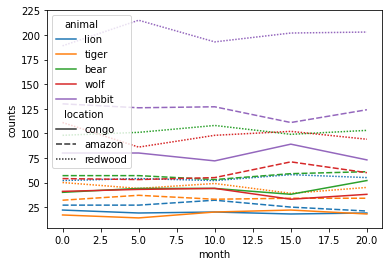

In [94]:
"Visualize the counts of each animal over time by location in one plot"
# As a challenge, add circular markers to this plot! (no for loops or matplotlib, there's an argument to pass to the seaborn function)
sns.lineplot(x='month', y='counts', hue='animal', style='location', data=merged)
plt.show()

# 7. Facetting
This looks pretty messy, let's visualize this data again, but [facet](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html) by `location` (create subplots based on `location`). We can easily make facet plots for relational data with the `sns.relplot()` function (https://seaborn.pydata.org/generated/seaborn.relplot.html).

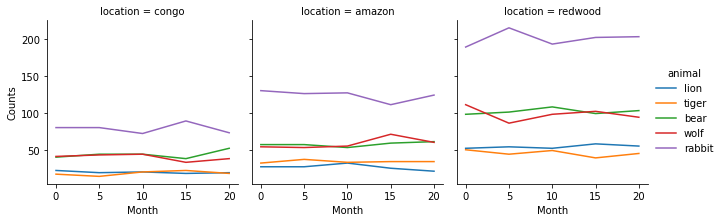

In [88]:
"Visualize counts of each animal facetted by location"
# Instead of a scatter plot, make it a lineplot, and make the size (hint: height) of each subplot smaller
g = sns.relplot(x='month', y='counts', hue='animal', col='location', kind='line', data=merged, height=3)
g.set_xlabels('Month')
g.set_ylabels('Counts')
plt.show()

# 8. Subsetting data
As an exercise, subset the `merged` to a new dataframe that just contains all of the 'lion' data from the 'redwood' location and then plot these counts as a barplot. Do this again with 'lion' and 'tiger'.

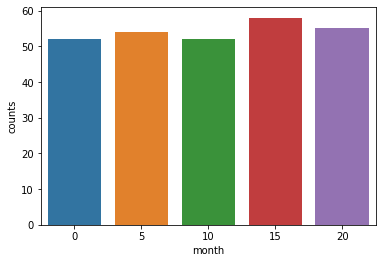

In [89]:
"Subset data to lion in redwood"
# Here I'm using "eq" for equals
lion_redwood = merged[merged.location.eq('redwood') & merged.animal.eq('lion')]
lion_redwood = merged[merge
"Visualize barplots"
sns.barplot(x='month', y='counts', data=lion_redwood)
plt.show()

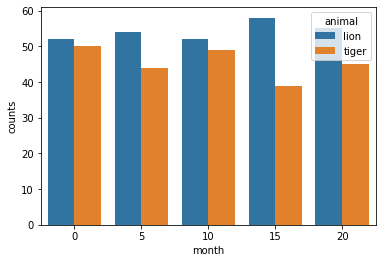

In [91]:
"Subset data to lion *and* tiger in redwood"
# Here I use "is_in" to subset to multiple items
lion_tiger_redwood = merged[merged.location.eq('redwood') & merged.animal.isin(['lion', 'tiger'])]

"Visualize barplots"
sns.barplot(x='month', y='counts', hue='animal', data=lion_tiger_redwood)
plt.show()

# 9. Relative abundance

The absolute count of each animal is interesting, but if we want to compare trends between locations, we may want to *normalize* our data by the total number of counts (divide the counts in each sample by the total number of counts for that sample). 

Normalize the counts data and re-produce the plot from **Problem 6**.

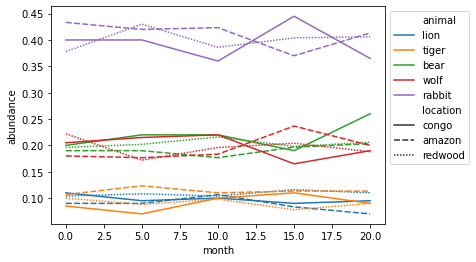

In [97]:
"Normalize counts"
# Let's start with the original counts and normalize that
## Sum of each sample. The (1) means take the sum of rows (instead of 0, which is the columns and the default behavior)
sample_sum = df.sum(1)
# Divide each sample (row) by this sample sum
normalized = df.divide(sample_sum, axis='index')

# Notice, that we can do this in one line
normalized = df.divide(df.sum(1), axis='index')

# We now have to melt and merge metadata
normalized_merged = normalized.stack().reset_index(name='abundance').merge(md)

"Visualize normalized counts"
sns.lineplot(x='month', y='abundance', hue='animal', style='location', data=normalized_merged)
# I'll move the legend
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

# 10. Challenge
Alice, Bobby, and Carl have weird parents. On 5 separate occasions, their parents have recorded how many Cheerios they ate that day and how high they were able to jump when they came home from school. The parents are interested in if there's any relationship between eating Cheerios and jumping high (there's not...) so they would like to visualize this data.


For each child, generate the number of cheerios they ate and how they jumped for five days, assuming that each kid eats different amounts of cheerios and jumps different a height on average. Create a single scatter plot of this data (Cheerios vs. jump height), colored by each kid. Draw arrows from between each subsequent time point for each child, keeping the colors of the arrows and the scatterpoints consistent for each child. Do this again, but create a subplot for each child.